# Query State Park Boundaries
a. stein 2/17/22

In [1]:
%pylab inline

import urllib.parse
import urllib.request

import geojson
import geopandas as gpd

import xarray as xr

#import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_gdf = gpd.read_file(states_url)

## Washington

In [3]:
wa_gdf = gpd.read_file('https://opendata.arcgis.com/datasets/3385b003af5248e59c1fa68e1411c446_0.geojson')
wa_gdf.head()

,OBJECTID,ParkName,Category,ParkCode,WebPage,Abbrv,Description,Imagelink,ManagementPlan_URL,ManagementPlan_PDF,Lat_Entrance,Long_Entrance,Acres,LABEL_LOCAL,SHAPE_Length,SHAPE_Area,geometry
0,1,Alta Lake,State Park,61000,http://parks.state.wa.us/239/Alta-Lake,ALL,Alta Lake State Park is a 174-acre camping par...,http://parks.state.wa.us/ImageRepository/Path?...,None,None,48.032181,-119.9347,174.474288,Alta Lake State Park,0.103181,8.509869e-05,"MULTIPOLYGON (((-119.92753 48.02374, -119.9274..."
1,2,Anderson Lake,State Park,58001,http://parks.state.wa.us/240/Anderson-Lake,ANL,None,None,None,None,48.014130,-122.8075,496.403199,Anderson Lake State Park,0.153846,2.420847e-04,"MULTIPOLYGON (((-122.80452 48.01318, -122.8044..."
2,3,Auburn,State Park Property,83503,,AUB,None,None,None,None,47.333881,-122.2206,1.599684,Auburn State Park Property,0.005044,7.705107e-07,"MULTIPOLYGON (((-122.21938 47.33369, -122.2193..."
3,4,Battle Ground Lake,State Park,41000,http://parks.state.wa.us/472/Battle-Ground-Lake,BGL,Battle Ground Lake State Park is a camping par...,http://parks.state.wa.us/ImageRepository/Path?...,None,None,45.802952,-122.4867,299.065669,Battle Ground Lake State Park,0.056478,1.400745e-04,"MULTIPOLYGON (((-122.49553 45.79951, -122.4955..."
4,5,Bay View,State Park,54001,http://parks.state.wa.us/473/Bay-View,BAV,Bay View State Park is a 66-acre camping park ...,http://parks.state.wa.us/ImageRepository/Path?...,None,None,48.487591,-122.4802,66.257905,Bay View State Park,0.037852,3.259054e-05,"MULTIPOLYGON (((-122.48136 48.49020, -122.4813..."


In [4]:
wa_bounds = wa_gdf.total_bounds # minx, miny, maxx, maxy

(45.54865808100004, 49.002095765000035)

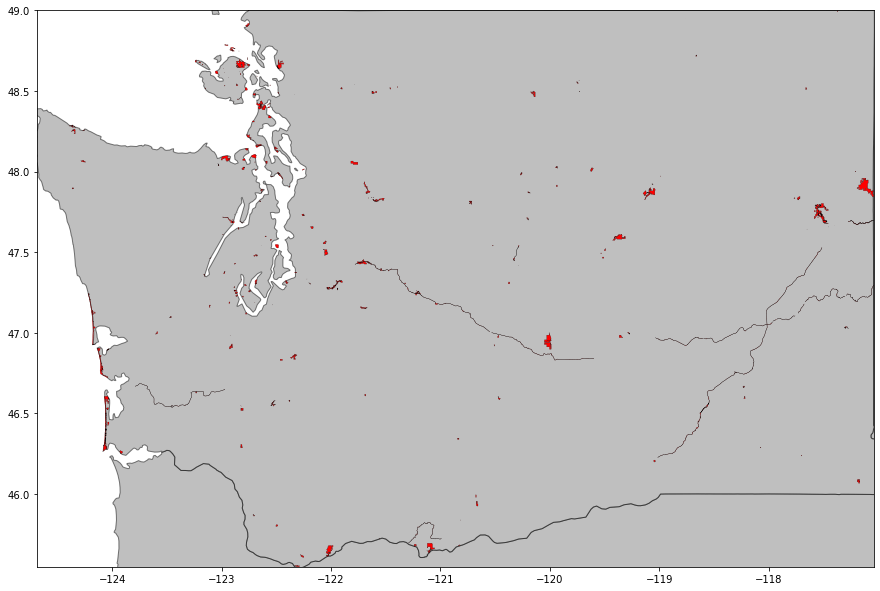

In [5]:
fig, ax = plt.subplots(figsize=(15,15))

states_gdf.to_crs(wa_gdf.crs).plot(ax=ax, facecolor='gray', edgecolor='k', alpha=0.5)
wa_gdf.plot(ax=ax, facecolor='r', edgecolor='k', linewidth=0.2)
ax.set_xlim(wa_bounds[0],wa_bounds[2])
ax.set_ylim(wa_bounds[1], wa_bounds[3])

So they all appear to be in WA fine ... but there are some strange scragly lines ... let's trim to the ones I have visitation data for.

In [6]:
wa_state_parks = xr.open_dataset('/pool0/home/steinadi/data/drought/drought_impact/data/wa_state_parks.nc')

In [36]:
retained_parks = []
rejected_parks = []

for park in wa_state_parks['park'].values:
    if park in wa_gdf.ParkName.values:
        retained_parks.append(park)
    else:
        rejected_parks.append(park)

In [37]:
len(retained_parks)

147

In [38]:
len(rejected_parks)

47

Let's check if it's simply a matter of something being repeated

In [50]:
mismatch_parks = []
still_rejected_parks = []

for rejected_park in rejected_parks:
    park_found = False
    for park in wa_gdf.ParkName.values:
        if park in rejected_park or rejected_park in park:
            park_found = True
    if park_found:
        mismatch_parks.append(rejected_park)
    else:
        still_rejected_parks.append(rejected_park)

In [51]:
mismatch_parks

['Fort Worden Conf Ctr',
 'Twin Harbors Beach',
 'Columbia Plateau Trail North',
 'Columbia Plateau Trail South',
 'ELC - Brooks Memorial',
 'ELC - Fort Flagler',
 'ELC - Lewis & Clark',
 'ELC - Millersylvania',
 'ELC - Moran',
 'Fisk Property',
 'IC - Fort Casey',
 'IC - Fort Columbia',
 'IC - Fort Flagler Museum',
 'IC - Fort Simcoe',
 'IC - Ginkgo Petrified Forest',
 'IC - Goldendale Observatory',
 'IC - Lewis & Clark',
 'IC - Sacajawea',
 'IC - Deception Pass CCC']

In [52]:
still_rejected_parks

['Iron Horse Kittitas',
 'Sun Lakes Resort',
 'Wanapum',
 'Grand Total',
 'Lake Spokane',
 'Iron Horse Easton',
 'Banks Lake',
 'Big Eddy',
 'Centennial Trail',
 'Dry Falls Visitor Ctr',
 'ELC - Camp Delany',
 'ELC - Camp Wooten',
 'ELC - Cornet Bay',
 'ELC - Puffer Butte',
 'ELC - Ramblewood',
 'ELC - Wo-He-Lo',
 'Griffith-Priday',
 'Iron Horse King',
 'Long Beach',
 'Mount St. Helens Visitor Ctr',
 'North Beach',
 'South Beach',
 'IC - Dry Falls Visitor Ctr',
 'IC - Marine Science Ctr',
 'IC - Mount St. Helens Visitor Ctr',
 'IC - Spokane House',
 'Westhaven',
 'Wolfe Property']

In [53]:
#list(wa_gdf.ParkName.values)

So going through that by hand, there were some plausible cases ... I think I'm not going to trim this data set. It does contain many geometries that I need and will keep it to that. If it turns out later that hanging onto the extra parks is causing a big slow-down, then I'll come back around and trim it.

In [54]:
wa_path = '../data/wa_state_park_bounds.geojson'

try:
    os.remove(wa_path)
except:
    pass

wa_gdf.to_file(wa_path)

In [55]:
gpd.read_file('../data/wa_state_park_bounds.geojson').head()

,OBJECTID,ParkName,Category,ParkCode,WebPage,Abbrv,Description,Imagelink,ManagementPlan_URL,ManagementPlan_PDF,Lat_Entrance,Long_Entrance,Acres,LABEL_LOCAL,SHAPE_Length,SHAPE_Area,geometry
0,1,Alta Lake,State Park,61000,http://parks.state.wa.us/239/Alta-Lake,ALL,Alta Lake State Park is a 174-acre camping par...,http://parks.state.wa.us/ImageRepository/Path?...,None,None,48.032181,-119.9347,174.474288,Alta Lake State Park,0.103181,8.509869e-05,"MULTIPOLYGON (((-119.92753 48.02374, -119.9274..."
1,2,Anderson Lake,State Park,58001,http://parks.state.wa.us/240/Anderson-Lake,ANL,None,None,None,None,48.014130,-122.8075,496.403199,Anderson Lake State Park,0.153846,2.420847e-04,"MULTIPOLYGON (((-122.80452 48.01318, -122.8044..."
2,3,Auburn,State Park Property,83503,,AUB,None,None,None,None,47.333881,-122.2206,1.599684,Auburn State Park Property,0.005044,7.705107e-07,"MULTIPOLYGON (((-122.21938 47.33369, -122.2193..."
3,4,Battle Ground Lake,State Park,41000,http://parks.state.wa.us/472/Battle-Ground-Lake,BGL,Battle Ground Lake State Park is a camping par...,http://parks.state.wa.us/ImageRepository/Path?...,None,None,45.802952,-122.4867,299.065669,Battle Ground Lake State Park,0.056478,1.400745e-04,"MULTIPOLYGON (((-122.49553 45.79951, -122.4955..."
4,5,Bay View,State Park,54001,http://parks.state.wa.us/473/Bay-View,BAV,Bay View State Park is a 66-acre camping park ...,http://parks.state.wa.us/ImageRepository/Path?...,None,None,48.487591,-122.4802,66.257905,Bay View State Park,0.037852,3.259054e-05,"MULTIPOLYGON (((-122.48136 48.49020, -122.4813..."


## Oregon

So the files I found for Oregon state parks turned out to be a geodatabase ... 

So I opened on my local computer with QGIS and exported the layer in the geodatabase to geojson ...

In [56]:
or_gdf = gpd.read_file('/pool0/home/steinadi/data/drought/drought_impact/data/OR_state_parks.geojson')
or_gdf.head()

,OBJECTID,PARK_HUB_ID,NAME,GIS_ACRES,EDITOR,EDITDATE,CREATOR,CREATEDATE,RETIREDATE,DATASOURCE,DESIGNATION,USE_TYPE,FULL_NAME,PUBLIC_DISPLAY,SHAPE_Length,SHAPE_Area,geometry
0,1,286,Rough and Ready,30.38,gis,2014-03-11T06:40:55,TConley,2009-06-16T13:55:46,None,Survey data,State Natural Site,Undeveloped,Rough and Ready State Natural Site,YES,5313.660577,1.323496e+06,"MULTIPOLYGON (((447521.457 143071.341, 448253...."
1,2,10002,Butteville Store,0.31,gis,2014-03-11T06:40:55,TConley,2009-06-16T13:55:46,None,Scanned engineering drawing or scaled map,,Day Use,Butteville Store,YES,555.637817,1.380625e+04,"MULTIPOLYGON (((709321.705 1288855.824, 709410..."
2,3,159,Government Island,1937.72,gis,2014-03-11T06:40:56,TConley,2009-06-16T13:55:47,None,Digital Orthophoto,State Recreation Area,Day Use,Government Island State Recreation Area,YES,93595.449942,8.440778e+07,"MULTIPOLYGON (((812760.421 1395737.421, 812763..."
3,4,272,Prospect,13.56,gis,2014-03-11T06:40:55,TConley,2009-06-16T13:55:46,None,Digital Orthophoto,State Scenic Viewpoint,Day Use,Prospect State Scenic Viewpoint,YES,5713.894556,5.910149e+05,"MULTIPOLYGON (((775226.939 367939.663, 775112...."
4,5,476,Frenchglen Corral,28.17,gis,2014-03-11T06:40:55,TConley,2009-06-16T13:55:47,None,Digital Orthophoto,,None,Frenchglen Corral,YES,5026.853775,1.227231e+06,"MULTIPOLYGON (((1736361.872 398308.884, 173640..."


In [57]:
or_bounds = or_gdf.total_bounds

(88699.71358267963, 1655108.1505905539)

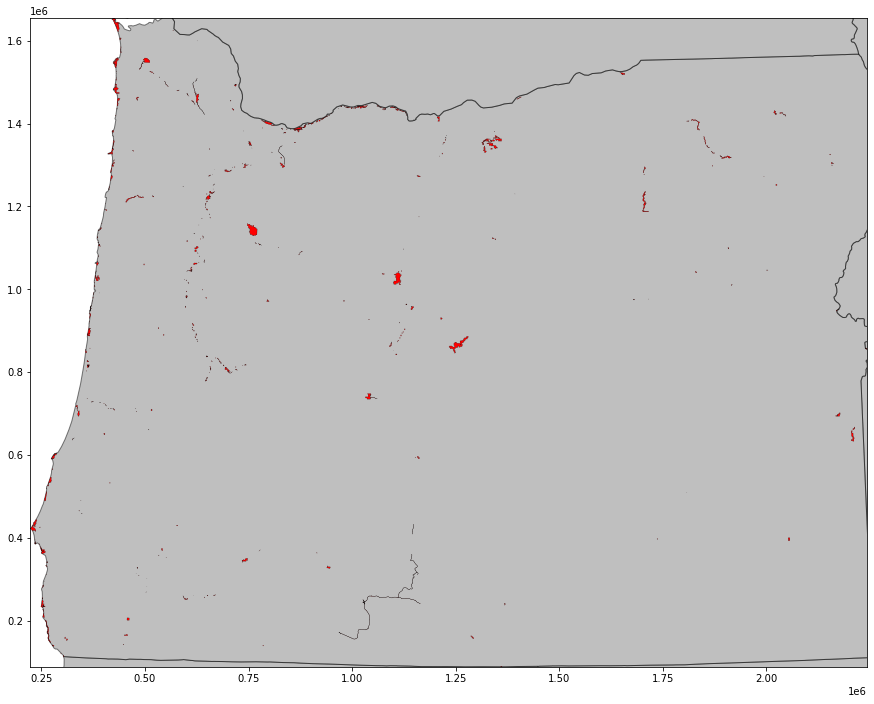

In [58]:
fig, ax = plt.subplots(figsize=(15,15))

states_gdf.to_crs(or_gdf.crs).plot(ax=ax, facecolor='gray', edgecolor='k', alpha=0.5)
or_gdf.plot(ax=ax, facecolor='r', edgecolor='k', linewidth=0.2)
ax.set_xlim(or_bounds[0],or_bounds[2])
ax.set_ylim(or_bounds[1], or_bounds[3])

In [60]:
or_state_parks = xr.open_dataset('/pool0/home/steinadi/data/drought/drought_impact/data/or_state_parks.nc')
or_state_parks

<xarray.Dataset>
Dimensions:    (time: 397, park: 259)
Coordinates:
  * time       (time) datetime64[ns] 1989-01-01 1989-02-01 ... 2022-01-01
  * park       (park) object 'AGATE BEACH STATE RECREATION SITE' ... 'TOTAL: ...
Data variables:
    day_user   (time, park) float64 ...
    overnight  (time, park) float64 ...

In [61]:
or_parks_with_data = or_state_parks['park'].values

In [63]:
or_parks_with_geo = or_gdf.FULL_NAME.values

In [69]:
found_geo = []
not_found = []

for park_data in or_parks_with_data:
    found = False
    for park_geo in or_parks_with_geo:
        if not park_geo is None:
            park_geo_u = park_geo.upper()
            if park_data in park_geo_u or park_geo_u in park_data:
                found = True
    if found:
        found_geo.append(park_data)
    else:
        not_found.append(park_data)

In [72]:
len(found_geo)

172

In [73]:
len(not_found)

87

In [74]:
not_found

['BEN & KAY DORRIS STATE RECREATION AREA',
 'BEN HUR LAMPMAN STATE SCENIC CORRIDOR',
 'BLUE MOUNTAIN MU ADMIN',
 'CASEY STATE RECREATION SITE',
 'CLARNO STATE PARK',
 'FALL CREEK- WINBERRY',
 'FORT STEVENS HISTORICAL AREA',
 'FORT YAMHILL STATE HERITAGE AREA',
 'GUY  W. TALBOT STATE PARK',
 'J. S. BURRES',
 'JENNIE B. HARRIS STATE RECREATION SITE',
 'L.L. "STUB" STEWART MEMORIAL STATE PARK',
 'LUCKIAMUTE LANDING STATE NATURAL AREA',
 'MARY S. YOUNG STATE RECREATION AREA',
 'MUNSON CREEK FALLS STATE NATURAL SITE',
 'OPHIR WAYSIDE',
 'ROCKAWAY BEACH STATE RECREATION SITE',
 'SHELTON STATE WAYSIDE',
 'TOUVELLE STATE RECREATION SITE',
 'TRYON CREEK MU ADMIN',
 'W. B. NELSON STATE RECREATION SITE',
 'WASHBURNE STATE WAYSIDE',
 "WILLAMETTE RIVER GREENWAY- BROWN'S LANDING",
 "WILLAMETTE RIVER GREENWAY- CHRISTENSEN'S BOAT RAMP",
 'WILLAMETTE RIVER GREENWAY- CLOVERDALE ACCESS',
 'WILLAMETTE RIVER GREENWAY- DARROW BAR ACCESS',
 'WILLAMETTE RIVER GREENWAY- FRENCH PRAIRIE ACCESS',
 'WILLAMETTE RIV

Alright, we are in a similar situation as the washington parks here, so I am again just not going to trim it.